### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
import os
from datetime import datetime

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
# Debug print flag 

DEBUG = False

#### Tracking the state-action pairs for checking convergence


In [4]:
def to_string(state_or_action):
    return ('-'.join(str(e) for e in state_or_action))

In [5]:
def initialise_tracking_states(state_space, action_space):
    for state in state_space:
        for action in action_space:
            state_str = to_string(state)
            action_str = to_string(action)
            States_track[state_str][action_str] = []

In [6]:
def save_tracking_states(curr_state, curr_action, q_value):
    for state in States_track.keys():
        if state == curr_state:
            for action in States_track[state].keys():
                if action == curr_action:
                    States_track[state][action].append(q_value)

In [7]:
# #Defining a function to save the Q-dictionary as a pickle file
# def save_obj(obj, name ):
#     with open(name + '.pkl', 'wb') as f:
#         pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size, action_space):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.action_space = action_space

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.99
        self.learning_rate = 0.001       
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.00065 #0.999
        self.epsilon_min = 0
        
        self.batch_size = 32    
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets
        model.add(Dense(32, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu',
                        kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='linear',
                        kernel_initializer='he_uniform'))
        # model.summary() 
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_epsilon(self, time):
        return self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*time)

    def get_action(self, state, time):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment       

        epsilon = self.get_epsilon(time)

        possible_actions_index, all_possible_actions = env.requests(state)

        if len(possible_actions_index) == 0:
            return all_possible_actions[0]

        if (np.random.rand() <= epsilon):
            return random.choice(all_possible_actions)
        # if generated random number is greater than ε, choose the action which has max Q-value
        else:
            state = env.state_encod_arch1(state)
            state = state.reshape(1, self.state_size)
            q_values = self.model.predict(state)[0]
            
            argmax = np.argmax(q_values[possible_actions_index])
#             DEBUG and print(f'q_values: {q_values}, available_q_vals: {q_values[possible_actions_index]}, argmax: {argmax}, all_possible_actions: {all_possible_actions}')
            return all_possible_actions[argmax]

    def append_sample(self, state, action, reward, next_state, isTerminal):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, isTerminal))
    
    def get_q_values(self, state):
        return self.model.predict(state)[0]
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_size)) # write here
            update_input = np.zeros((self.batch_size, self.state_size)) # write here
            
            actions, rewards, terminal_states  = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, isTerminal = mini_batch[i]
                # Write your code from here
                # 1. Predict the target from earlier model
                update_input[i] = env.state_encod_arch1(state).reshape(1, self.state_size)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state).reshape(1, self.state_size)   
                terminal_states.append(isTerminal)
                
            # 2. Get the target for the Q-network
            target = self.model.predict(update_input)
            target_qval = self.model.predict(update_output)
            
            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                action_idx = action_space.index(actions[i])
                if terminal_states[i]:                    
                    target[i][action_idx] = rewards[i]
                else: # non-terminal state
                    target[i][action_idx] = rewards[i] + self.discount_factor * np.max(target_qval[i])                    
                    
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    def save(self, name):
        self.model.save(name)

In [9]:
Episodes = 10000

env = CabDriver()
action_space, state_space, state = env.reset()
action_size = len(action_space)
state_size = len(env.state_encod_arch1(state_space[0]))

agent = DQNAgent(state_size, action_size, action_space)

States_track = collections.defaultdict(dict)
initialise_tracking_states(state_space, action_space)

# create folder with current time stamp
DIR_NAME = os.path.join(
        os.getcwd(), 
        'model-' + datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
os.makedirs(DIR_NAME)

agent.epsilon_decay = 80.0/(Episodes * 10)

scores = {}

start_time = time.time()

### DQN block

In [10]:
for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    

    #Call the DQN agent

    day = 0
    score = 0
    terminal_state = False

    # reset the state before new episode
    _, _, state = env.reset()
    initial_state = state
        
    while not terminal_state:        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        
        action = agent.get_action(state, episode)

        # 2. Evaluate your reward and next state
        next_state, reward = env.step(state, action, Time_matrix)
        
        # 3. Append the experience to the memory
        agent.append_sample(state, action, reward, next_state, terminal_state)
        
        # 4. Train the model by calling function agent.train_model
        agent.train_model()
        
        # 5. Keep a track of rewards, Q-values, loss
        score += reward
        
        # increase the date if the day is changed
        if next_state[2] != state[2]:
            day = day + 1
        
        DEBUG and print(f'state: {state}, action: {action}, next_state: {next_state}, reward: {reward}, day: {day}')

        # for tracking
        state_enc = env.state_encod_arch1(state)
        state_enc = np.reshape(state_enc, [1, 36])
        q_values = agent.get_q_values(state_enc)
        
        state_string = to_string(state)
        
        for index in range(len(env.action_space)):
            action_string = to_string(env.action_space[index])
            save_tracking_states(state_string, action_string, q_values[index])
            
        if day > 30:
            terminal_state = True
            
        state = next_state

    print(f'Score {episode}: {score}')
    scores[episode] = score
    
    if ((episode + 1) % 10 == 0):
        agent.save(DIR_NAME + '\\' + str(episode) + '.h5')


elapsed_time = time.time() - start_time
print(f'Entire Operation took {elapsed_time} seconds')



Score 0: -499.0
Score 1: -147.0
Score 2: -98.0
Score 3: 113.0
Score 4: -35.0
Score 5: 53.0
Score 6: -131.0
Score 7: -5.0
Score 8: -215.0
Score 9: -36.0
Score 10: 8.0
Score 11: -30.0
Score 12: -252.0
Score 13: -13.0
Score 14: -5.0
Score 15: -63.0
Score 16: -45.0
Score 17: -109.0
Score 18: -80.0
Score 19: -77.0
Score 20: -243.0
Score 21: -203.0
Score 22: -129.0
Score 23: -387.0
Score 24: -199.0
Score 25: -246.0
Score 26: -228.0
Score 27: -39.0
Score 28: -292.0
Score 29: -184.0
Score 30: 33.0
Score 31: -278.0
Score 32: -53.0
Score 33: -125.0
Score 34: 131.0
Score 35: 66.0
Score 36: -48.0
Score 37: -85.0
Score 38: -189.0
Score 39: -122.0
Score 40: -414.0
Score 41: -102.0
Score 42: -276.0
Score 43: -387.0
Score 44: -301.0
Score 45: -246.0
Score 46: -230.0
Score 47: -247.0
Score 48: 3.0
Score 49: -396.0
Score 50: -84.0
Score 51: -455.0
Score 52: -86.0
Score 53: -18.0
Score 54: -261.0
Score 55: 145.0
Score 56: 26.0
Score 57: 84.0
Score 58: -131.0
Score 59: 20.0
Score 60: -201.0
Score 61: -9

Score 465: 357.0
Score 466: 310.0
Score 467: 201.0
Score 468: 514.0
Score 469: 392.0
Score 470: 379.0
Score 471: 213.0
Score 472: 128.0
Score 473: 190.0
Score 474: 294.0
Score 475: 370.0
Score 476: 378.0
Score 477: 598.0
Score 478: 631.0
Score 479: 562.0
Score 480: 284.0
Score 481: 593.0
Score 482: 491.0
Score 483: 478.0
Score 484: 228.0
Score 485: 267.0
Score 486: 322.0
Score 487: 213.0
Score 488: 577.0
Score 489: 44.0
Score 490: 419.0
Score 491: 198.0
Score 492: 515.0
Score 493: 325.0
Score 494: 215.0
Score 495: 484.0
Score 496: 729.0
Score 497: 514.0
Score 498: 285.0
Score 499: 276.0
Score 500: 419.0
Score 501: 224.0
Score 502: 564.0
Score 503: 23.0
Score 504: 649.0
Score 505: 240.0
Score 506: 267.0
Score 507: 384.0
Score 508: 218.0
Score 509: 468.0
Score 510: 31.0
Score 511: 446.0
Score 512: 268.0
Score 513: 543.0
Score 514: 270.0
Score 515: 71.0
Score 516: 328.0
Score 517: 405.0
Score 518: 249.0
Score 519: 31.0
Score 520: 315.0
Score 521: 608.0
Score 522: 126.0
Score 523: 314.0
Sc

Score 948: 703.0
Score 949: 507.0
Score 950: 856.0
Score 951: 876.0
Score 952: 1131.0
Score 953: 531.0
Score 954: 501.0
Score 955: 450.0
Score 956: 446.0
Score 957: 586.0
Score 958: 719.0
Score 959: 904.0
Score 960: 702.0
Score 961: 601.0
Score 962: 755.0
Score 963: 827.0
Score 964: 1198.0
Score 965: 429.0
Score 966: 478.0
Score 967: 908.0
Score 968: 910.0
Score 969: 836.0
Score 970: 885.0
Score 971: 525.0
Score 972: 783.0
Score 973: 725.0
Score 974: 438.0
Score 975: 856.0
Score 976: 631.0
Score 977: 757.0
Score 978: 501.0
Score 979: 901.0
Score 980: 908.0
Score 981: 1013.0
Score 982: 454.0
Score 983: 829.0
Score 984: 654.0
Score 985: 792.0
Score 986: 503.0
Score 987: 836.0
Score 988: 1032.0
Score 989: 1027.0
Score 990: 652.0
Score 991: 640.0
Score 992: 980.0
Score 993: 962.0
Score 994: 834.0
Score 995: 802.0
Score 996: 872.0
Score 997: 753.0
Score 998: 670.0
Score 999: 584.0
Score 1000: 843.0
Score 1001: 778.0
Score 1002: 999.0
Score 1003: 558.0
Score 1004: 890.0
Score 1005: 835.0
Sco

Score 1401: 1063.0
Score 1402: 906.0
Score 1403: 1334.0
Score 1404: 764.0
Score 1405: 1031.0
Score 1406: 494.0
Score 1407: 1030.0
Score 1408: 1221.0
Score 1409: 803.0
Score 1410: 870.0
Score 1411: 860.0
Score 1412: 824.0
Score 1413: 815.0
Score 1414: 868.0
Score 1415: 748.0
Score 1416: 1079.0
Score 1417: 930.0
Score 1418: 663.0
Score 1419: 908.0
Score 1420: 945.0
Score 1421: 1018.0
Score 1422: 886.0
Score 1423: 872.0
Score 1424: 1033.0
Score 1425: 1297.0
Score 1426: 886.0
Score 1427: 620.0
Score 1428: 872.0
Score 1429: 903.0
Score 1430: 768.0
Score 1431: 1173.0
Score 1432: 958.0
Score 1433: 788.0
Score 1434: 827.0
Score 1435: 1234.0
Score 1436: 828.0
Score 1437: 1193.0
Score 1438: 757.0
Score 1439: 1131.0
Score 1440: 1165.0
Score 1441: 928.0
Score 1442: 1081.0
Score 1443: 1135.0
Score 1444: 995.0
Score 1445: 1036.0
Score 1446: 906.0
Score 1447: 1090.0
Score 1448: 1066.0
Score 1449: 996.0
Score 1450: 1053.0
Score 1451: 1063.0
Score 1452: 1115.0
Score 1453: 1475.0
Score 1454: 918.0
Score

Score 1841: 1234.0
Score 1842: 1194.0
Score 1843: 1043.0
Score 1844: 865.0
Score 1845: 1549.0
Score 1846: 921.0
Score 1847: 1274.0
Score 1848: 1138.0
Score 1849: 1324.0
Score 1850: 1039.0
Score 1851: 1151.0
Score 1852: 995.0
Score 1853: 1180.0
Score 1854: 1312.0
Score 1855: 1023.0
Score 1856: 1049.0
Score 1857: 1196.0
Score 1858: 1407.0
Score 1859: 907.0
Score 1860: 1663.0
Score 1861: 824.0
Score 1862: 1141.0
Score 1863: 906.0
Score 1864: 984.0
Score 1865: 1406.0
Score 1866: 773.0
Score 1867: 923.0
Score 1868: 1364.0
Score 1869: 951.0
Score 1870: 1320.0
Score 1871: 1097.0
Score 1872: 1394.0
Score 1873: 1229.0
Score 1874: 724.0
Score 1875: 1354.0
Score 1876: 1035.0
Score 1877: 1345.0
Score 1878: 1183.0
Score 1879: 1304.0
Score 1880: 1335.0
Score 1881: 977.0
Score 1882: 1122.0
Score 1883: 1472.0
Score 1884: 1170.0
Score 1885: 941.0
Score 1886: 1439.0
Score 1887: 1446.0
Score 1888: 996.0
Score 1889: 1021.0
Score 1890: 1079.0
Score 1891: 1107.0
Score 1892: 885.0
Score 1893: 1005.0
Score 18

Score 2276: 1348.0
Score 2277: 1076.0
Score 2278: 1157.0
Score 2279: 1086.0
Score 2280: 1563.0
Score 2281: 1194.0
Score 2282: 973.0
Score 2283: 1311.0
Score 2284: 990.0
Score 2285: 1028.0
Score 2286: 1562.0
Score 2287: 1430.0
Score 2288: 1507.0
Score 2289: 1288.0
Score 2290: 1183.0
Score 2291: 1172.0
Score 2292: 1482.0
Score 2293: 1304.0
Score 2294: 1157.0
Score 2295: 1112.0
Score 2296: 1293.0
Score 2297: 1378.0
Score 2298: 1178.0
Score 2299: 1223.0
Score 2300: 1265.0
Score 2301: 1472.0
Score 2302: 1232.0
Score 2303: 1238.0
Score 2304: 908.0
Score 2305: 1274.0
Score 2306: 1071.0
Score 2307: 1285.0
Score 2308: 1491.0
Score 2309: 1543.0
Score 2310: 1513.0
Score 2311: 1321.0
Score 2312: 1137.0
Score 2313: 1216.0
Score 2314: 1545.0
Score 2315: 1207.0
Score 2316: 1268.0
Score 2317: 1478.0
Score 2318: 1138.0
Score 2319: 1080.0
Score 2320: 1369.0
Score 2321: 1355.0
Score 2322: 1435.0
Score 2323: 1078.0
Score 2324: 1233.0
Score 2325: 1284.0
Score 2326: 1244.0
Score 2327: 1406.0
Score 2328: 151

Score 2708: 1230.0
Score 2709: 1229.0
Score 2710: 1525.0
Score 2711: 1243.0
Score 2712: 1544.0
Score 2713: 1490.0
Score 2714: 1286.0
Score 2715: 1119.0
Score 2716: 1563.0
Score 2717: 1621.0
Score 2718: 1349.0
Score 2719: 1059.0
Score 2720: 1183.0
Score 2721: 1394.0
Score 2722: 1201.0
Score 2723: 1392.0
Score 2724: 1831.0
Score 2725: 1265.0
Score 2726: 1450.0
Score 2727: 1138.0
Score 2728: 1245.0
Score 2729: 1493.0
Score 2730: 1311.0
Score 2731: 1300.0
Score 2732: 1566.0
Score 2733: 1444.0
Score 2734: 1467.0
Score 2735: 1301.0
Score 2736: 1351.0
Score 2737: 1156.0
Score 2738: 1153.0
Score 2739: 998.0
Score 2740: 1606.0
Score 2741: 1126.0
Score 2742: 1050.0
Score 2743: 1309.0
Score 2744: 1616.0
Score 2745: 1474.0
Score 2746: 1777.0
Score 2747: 1233.0
Score 2748: 1792.0
Score 2749: 1135.0
Score 2750: 1476.0
Score 2751: 1687.0
Score 2752: 1392.0
Score 2753: 1275.0
Score 2754: 1392.0
Score 2755: 1678.0
Score 2756: 1608.0
Score 2757: 1113.0
Score 2758: 1474.0
Score 2759: 1317.0
Score 2760: 1

Score 3140: 1481.0
Score 3141: 1369.0
Score 3142: 1282.0
Score 3143: 1734.0
Score 3144: 1724.0
Score 3145: 1486.0
Score 3146: 1446.0
Score 3147: 1175.0
Score 3148: 1223.0
Score 3149: 1754.0
Score 3150: 1592.0
Score 3151: 1562.0
Score 3152: 1256.0
Score 3153: 1349.0
Score 3154: 1311.0
Score 3155: 1684.0
Score 3156: 1493.0
Score 3157: 1558.0
Score 3158: 1401.0
Score 3159: 1427.0
Score 3160: 1419.0
Score 3161: 1428.0
Score 3162: 1545.0
Score 3163: 1396.0
Score 3164: 1689.0
Score 3165: 1642.0
Score 3166: 1364.0
Score 3167: 1363.0
Score 3168: 1338.0
Score 3169: 1341.0
Score 3170: 1439.0
Score 3171: 1437.0
Score 3172: 1554.0
Score 3173: 1406.0
Score 3174: 1592.0
Score 3175: 1320.0
Score 3176: 1312.0
Score 3177: 1616.0
Score 3178: 1332.0
Score 3179: 1567.0
Score 3180: 1367.0
Score 3181: 1383.0
Score 3182: 1143.0
Score 3183: 1671.0
Score 3184: 1446.0
Score 3185: 1772.0
Score 3186: 1543.0
Score 3187: 1585.0
Score 3188: 1507.0
Score 3189: 1574.0
Score 3190: 1297.0
Score 3191: 1356.0
Score 3192: 

Score 3572: 1797.0
Score 3573: 1319.0
Score 3574: 1392.0
Score 3575: 1644.0
Score 3576: 1497.0
Score 3577: 1347.0
Score 3578: 1718.0
Score 3579: 1345.0
Score 3580: 1774.0
Score 3581: 1527.0
Score 3582: 1623.0
Score 3583: 1471.0
Score 3584: 1414.0
Score 3585: 1446.0
Score 3586: 1174.0
Score 3587: 1400.0
Score 3588: 1473.0
Score 3589: 1284.0
Score 3590: 1180.0
Score 3591: 1568.0
Score 3592: 1603.0
Score 3593: 1130.0
Score 3594: 1380.0
Score 3595: 1473.0
Score 3596: 1528.0
Score 3597: 1531.0
Score 3598: 1508.0
Score 3599: 1540.0
Score 3600: 1544.0
Score 3601: 1621.0
Score 3602: 1856.0
Score 3603: 1574.0
Score 3604: 1151.0
Score 3605: 1778.0
Score 3606: 1684.0
Score 3607: 1538.0
Score 3608: 1265.0
Score 3609: 1424.0
Score 3610: 1737.0
Score 3611: 1571.0
Score 3612: 1185.0
Score 3613: 1437.0
Score 3614: 1592.0
Score 3615: 1691.0
Score 3616: 1446.0
Score 3617: 1462.0
Score 3618: 1533.0
Score 3619: 1383.0
Score 3620: 1813.0
Score 3621: 1291.0
Score 3622: 1504.0
Score 3623: 1575.0
Score 3624: 

Score 4004: 1178.0
Score 4005: 1411.0
Score 4006: 1603.0
Score 4007: 1607.0
Score 4008: 1608.0
Score 4009: 1203.0
Score 4010: 1813.0
Score 4011: 1410.0
Score 4012: 1660.0
Score 4013: 1887.0
Score 4014: 1399.0
Score 4015: 1449.0
Score 4016: 1377.0
Score 4017: 1482.0
Score 4018: 1823.0
Score 4019: 1528.0
Score 4020: 1630.0
Score 4021: 1396.0
Score 4022: 1475.0
Score 4023: 1643.0
Score 4024: 1422.0
Score 4025: 1437.0
Score 4026: 1696.0
Score 4027: 1646.0
Score 4028: 1763.0
Score 4029: 1322.0
Score 4030: 1394.0
Score 4031: 1660.0
Score 4032: 1752.0
Score 4033: 1211.0
Score 4034: 1522.0
Score 4035: 1530.0
Score 4036: 1522.0
Score 4037: 1643.0
Score 4038: 1725.0
Score 4039: 1511.0
Score 4040: 1927.0
Score 4041: 1471.0
Score 4042: 1671.0
Score 4043: 1734.0
Score 4044: 1463.0
Score 4045: 1436.0
Score 4046: 1484.0
Score 4047: 1657.0
Score 4048: 1480.0
Score 4049: 1738.0
Score 4050: 1687.0
Score 4051: 1505.0
Score 4052: 1322.0
Score 4053: 1991.0
Score 4054: 1702.0
Score 4055: 1884.0
Score 4056: 

Score 4436: 1612.0
Score 4437: 1558.0
Score 4438: 1570.0
Score 4439: 1180.0
Score 4440: 1347.0
Score 4441: 1711.0
Score 4442: 1706.0
Score 4443: 1609.0
Score 4444: 1320.0
Score 4445: 1226.0
Score 4446: 1588.0
Score 4447: 1524.0
Score 4448: 1464.0
Score 4449: 1516.0
Score 4450: 1534.0
Score 4451: 1586.0
Score 4452: 1580.0
Score 4453: 1778.0
Score 4454: 1682.0
Score 4455: 1829.0
Score 4456: 1585.0
Score 4457: 1770.0
Score 4458: 1351.0
Score 4459: 1428.0
Score 4460: 1248.0
Score 4461: 1754.0
Score 4462: 1304.0
Score 4463: 1550.0
Score 4464: 1422.0
Score 4465: 1420.0
Score 4466: 1504.0
Score 4467: 1606.0
Score 4468: 1611.0
Score 4469: 1608.0
Score 4470: 1603.0
Score 4471: 1334.0
Score 4472: 1604.0
Score 4473: 1729.0
Score 4474: 1567.0
Score 4475: 1418.0
Score 4476: 1536.0
Score 4477: 1408.0
Score 4478: 1534.0
Score 4479: 1455.0
Score 4480: 1550.0
Score 4481: 1489.0
Score 4482: 1718.0
Score 4483: 1320.0
Score 4484: 1824.0
Score 4485: 1608.0
Score 4486: 1427.0
Score 4487: 1383.0
Score 4488: 

Score 4868: 1683.0
Score 4869: 1841.0
Score 4870: 1660.0
Score 4871: 1599.0
Score 4872: 1499.0
Score 4873: 1616.0
Score 4874: 1911.0
Score 4875: 1895.0
Score 4876: 1597.0
Score 4877: 1517.0
Score 4878: 1486.0
Score 4879: 1902.0
Score 4880: 1495.0
Score 4881: 1259.0
Score 4882: 1448.0
Score 4883: 1545.0
Score 4884: 1553.0
Score 4885: 1642.0
Score 4886: 1698.0
Score 4887: 1760.0
Score 4888: 1429.0
Score 4889: 1643.0
Score 4890: 1507.0
Score 4891: 1984.0
Score 4892: 1518.0
Score 4893: 1894.0
Score 4894: 1752.0
Score 4895: 1536.0
Score 4896: 1592.0
Score 4897: 1567.0
Score 4898: 1368.0
Score 4899: 1382.0
Score 4900: 1391.0
Score 4901: 1545.0
Score 4902: 1864.0
Score 4903: 1981.0
Score 4904: 1490.0
Score 4905: 1563.0
Score 4906: 1687.0
Score 4907: 1724.0
Score 4908: 1342.0
Score 4909: 1674.0
Score 4910: 1656.0
Score 4911: 1562.0
Score 4912: 1720.0
Score 4913: 1706.0
Score 4914: 1527.0
Score 4915: 1482.0
Score 4916: 1826.0
Score 4917: 1444.0
Score 4918: 1455.0
Score 4919: 1886.0
Score 4920: 

Score 5300: 1621.0
Score 5301: 1770.0
Score 5302: 1547.0
Score 5303: 1255.0
Score 5304: 1572.0
Score 5305: 1950.0
Score 5306: 2004.0
Score 5307: 1693.0
Score 5308: 1471.0
Score 5309: 1588.0
Score 5310: 1542.0
Score 5311: 1464.0
Score 5312: 1734.0
Score 5313: 1481.0
Score 5314: 1738.0
Score 5315: 1480.0
Score 5316: 1768.0
Score 5317: 1342.0
Score 5318: 1772.0
Score 5319: 1599.0
Score 5320: 1502.0
Score 5321: 1286.0
Score 5322: 1495.0
Score 5323: 1607.0
Score 5324: 1582.0
Score 5325: 1331.0
Score 5326: 1502.0
Score 5327: 1935.0
Score 5328: 1666.0
Score 5329: 1594.0
Score 5330: 1689.0
Score 5331: 1886.0
Score 5332: 1610.0
Score 5333: 1347.0
Score 5334: 1661.0
Score 5335: 1926.0
Score 5336: 1615.0
Score 5337: 1534.0
Score 5338: 1360.0
Score 5339: 1529.0
Score 5340: 2149.0
Score 5341: 1727.0
Score 5342: 1923.0
Score 5343: 1840.0
Score 5344: 1653.0
Score 5345: 1661.0
Score 5346: 1723.0
Score 5347: 1511.0
Score 5348: 1696.0
Score 5349: 1471.0
Score 5350: 1672.0
Score 5351: 1814.0
Score 5352: 

Score 5732: 1896.0
Score 5733: 1559.0
Score 5734: 1623.0
Score 5735: 1755.0
Score 5736: 1606.0
Score 5737: 1513.0
Score 5738: 1795.0
Score 5739: 1545.0
Score 5740: 1756.0
Score 5741: 1832.0
Score 5742: 1864.0
Score 5743: 1785.0
Score 5744: 1660.0
Score 5745: 1698.0
Score 5746: 1824.0
Score 5747: 1603.0
Score 5748: 1786.0
Score 5749: 1565.0
Score 5750: 1414.0
Score 5751: 1485.0
Score 5752: 1904.0
Score 5753: 1593.0
Score 5754: 1610.0
Score 5755: 1762.0
Score 5756: 1621.0
Score 5757: 1720.0
Score 5758: 1882.0
Score 5759: 1706.0
Score 5760: 1495.0
Score 5761: 1833.0
Score 5762: 1875.0
Score 5763: 1565.0
Score 5764: 1558.0
Score 5765: 1709.0
Score 5766: 1502.0
Score 5767: 1725.0
Score 5768: 1432.0
Score 5769: 1725.0
Score 5770: 1626.0
Score 5771: 1777.0
Score 5772: 1545.0
Score 5773: 1770.0
Score 5774: 1558.0
Score 5775: 1772.0
Score 5776: 1707.0
Score 5777: 1743.0
Score 5778: 1427.0
Score 5779: 1795.0
Score 5780: 1671.0
Score 5781: 1410.0
Score 5782: 1581.0
Score 5783: 1736.0
Score 5784: 

Score 6164: 1521.0
Score 6165: 1745.0
Score 6166: 1725.0
Score 6167: 1594.0
Score 6168: 1220.0
Score 6169: 1635.0
Score 6170: 1575.0
Score 6171: 1760.0
Score 6172: 1633.0
Score 6173: 1612.0
Score 6174: 1284.0
Score 6175: 1747.0
Score 6176: 1626.0
Score 6177: 1683.0
Score 6178: 1742.0
Score 6179: 1475.0
Score 6180: 1554.0
Score 6181: 1752.0
Score 6182: 1735.0
Score 6183: 1414.0
Score 6184: 1675.0
Score 6185: 1563.0
Score 6186: 1363.0
Score 6187: 1668.0
Score 6188: 1337.0
Score 6189: 1552.0
Score 6190: 1627.0
Score 6191: 1692.0
Score 6192: 1732.0
Score 6193: 1837.0
Score 6194: 1770.0
Score 6195: 1786.0
Score 6196: 1756.0
Score 6197: 1412.0
Score 6198: 1524.0
Score 6199: 1720.0
Score 6200: 1673.0
Score 6201: 1837.0
Score 6202: 1684.0
Score 6203: 1707.0
Score 6204: 1643.0
Score 6205: 1705.0
Score 6206: 1769.0
Score 6207: 1603.0
Score 6208: 1607.0
Score 6209: 1723.0
Score 6210: 1743.0
Score 6211: 1589.0
Score 6212: 1576.0
Score 6213: 1597.0
Score 6214: 1623.0
Score 6215: 1489.0
Score 6216: 

Score 6596: 1523.0
Score 6597: 1603.0
Score 6598: 1485.0
Score 6599: 1750.0
Score 6600: 1581.0
Score 6601: 1647.0
Score 6602: 1426.0
Score 6603: 1698.0
Score 6604: 1858.0
Score 6605: 1779.0
Score 6606: 1590.0
Score 6607: 1364.0
Score 6608: 1733.0
Score 6609: 1731.0
Score 6610: 1688.0
Score 6611: 1503.0
Score 6612: 1880.0
Score 6613: 1799.0
Score 6614: 1725.0
Score 6615: 1745.0
Score 6616: 1777.0
Score 6617: 1756.0
Score 6618: 1448.0
Score 6619: 1758.0
Score 6620: 1540.0
Score 6621: 1740.0
Score 6622: 1768.0
Score 6623: 1522.0
Score 6624: 1692.0
Score 6625: 1807.0
Score 6626: 1909.0
Score 6627: 1873.0
Score 6628: 1958.0
Score 6629: 1644.0
Score 6630: 1655.0
Score 6631: 1785.0
Score 6632: 1635.0
Score 6633: 1509.0
Score 6634: 1660.0
Score 6635: 1450.0
Score 6636: 1633.0
Score 6637: 1876.0
Score 6638: 1840.0
Score 6639: 1653.0
Score 6640: 1880.0
Score 6641: 1497.0
Score 6642: 1590.0
Score 6643: 1598.0
Score 6644: 1636.0
Score 6645: 1697.0
Score 6646: 1601.0
Score 6647: 1667.0
Score 6648: 

Score 7028: 1764.0
Score 7029: 1506.0
Score 7030: 1549.0
Score 7031: 1457.0
Score 7032: 1790.0
Score 7033: 1401.0
Score 7034: 1518.0
Score 7035: 1819.0
Score 7036: 1787.0
Score 7037: 1536.0
Score 7038: 1685.0
Score 7039: 1446.0
Score 7040: 1828.0
Score 7041: 1797.0
Score 7042: 1752.0
Score 7043: 1803.0
Score 7044: 1477.0
Score 7045: 1641.0
Score 7046: 1585.0
Score 7047: 1774.0
Score 7048: 1504.0
Score 7049: 1706.0
Score 7050: 1525.0
Score 7051: 1544.0
Score 7052: 1768.0
Score 7053: 1528.0
Score 7054: 1550.0
Score 7055: 1504.0
Score 7056: 1713.0
Score 7057: 1644.0
Score 7058: 1404.0
Score 7059: 1905.0
Score 7060: 1716.0
Score 7061: 1563.0
Score 7062: 1659.0
Score 7063: 1747.0
Score 7064: 1625.0
Score 7065: 1625.0
Score 7066: 1378.0
Score 7067: 1606.0
Score 7068: 1721.0
Score 7069: 1736.0
Score 7070: 1270.0
Score 7071: 1708.0
Score 7072: 1376.0
Score 7073: 1597.0
Score 7074: 1599.0
Score 7075: 1818.0
Score 7076: 1923.0
Score 7077: 1756.0
Score 7078: 1610.0
Score 7079: 1535.0
Score 7080: 

Score 7460: 1910.0
Score 7461: 1823.0
Score 7462: 1790.0
Score 7463: 1642.0
Score 7464: 1610.0
Score 7465: 1628.0
Score 7466: 1743.0
Score 7467: 1882.0
Score 7468: 1472.0
Score 7469: 1853.0
Score 7470: 1711.0
Score 7471: 1698.0
Score 7472: 1608.0
Score 7473: 1498.0
Score 7474: 1754.0
Score 7475: 1284.0
Score 7476: 1890.0
Score 7477: 1660.0
Score 7478: 1945.0
Score 7479: 1972.0
Score 7480: 1651.0
Score 7481: 1783.0
Score 7482: 1832.0
Score 7483: 1697.0
Score 7484: 1670.0
Score 7485: 1873.0
Score 7486: 1767.0
Score 7487: 1839.0
Score 7488: 1504.0
Score 7489: 1393.0
Score 7490: 1435.0
Score 7491: 1673.0
Score 7492: 1572.0
Score 7493: 1456.0
Score 7494: 1785.0
Score 7495: 1849.0
Score 7496: 1673.0
Score 7497: 1695.0
Score 7498: 1637.0
Score 7499: 1516.0
Score 7500: 1527.0
Score 7501: 1625.0
Score 7502: 1787.0
Score 7503: 1705.0
Score 7504: 1445.0
Score 7505: 1563.0
Score 7506: 1653.0
Score 7507: 1557.0
Score 7508: 1689.0
Score 7509: 1623.0
Score 7510: 1547.0
Score 7511: 1175.0
Score 7512: 

Score 7892: 1525.0
Score 7893: 1688.0
Score 7894: 1575.0
Score 7895: 1847.0
Score 7896: 1760.0
Score 7897: 2010.0
Score 7898: 1695.0
Score 7899: 1412.0
Score 7900: 1957.0
Score 7901: 1641.0
Score 7902: 1683.0
Score 7903: 1862.0
Score 7904: 1567.0
Score 7905: 1651.0
Score 7906: 1617.0
Score 7907: 1599.0
Score 7908: 1716.0
Score 7909: 1783.0
Score 7910: 1556.0
Score 7911: 1800.0
Score 7912: 1562.0
Score 7913: 1536.0
Score 7914: 1459.0
Score 7915: 1728.0
Score 7916: 1829.0
Score 7917: 1509.0
Score 7918: 1829.0
Score 7919: 1625.0
Score 7920: 1562.0
Score 7921: 1516.0
Score 7922: 1716.0
Score 7923: 1590.0
Score 7924: 1804.0
Score 7925: 1499.0
Score 7926: 1897.0
Score 7927: 1624.0
Score 7928: 1671.0
Score 7929: 1863.0
Score 7930: 1805.0
Score 7931: 1995.0
Score 7932: 1795.0
Score 7933: 1624.0
Score 7934: 1759.0
Score 7935: 1657.0
Score 7936: 1662.0
Score 7937: 1944.0
Score 7938: 1715.0
Score 7939: 1471.0
Score 7940: 1379.0
Score 7941: 1894.0
Score 7942: 1340.0
Score 7943: 1760.0
Score 7944: 

Score 8324: 1651.0
Score 8325: 1340.0
Score 8326: 1668.0
Score 8327: 1350.0
Score 8328: 1790.0
Score 8329: 1656.0
Score 8330: 1891.0
Score 8331: 1714.0
Score 8332: 1606.0
Score 8333: 1528.0
Score 8334: 1266.0
Score 8335: 1846.0
Score 8336: 1808.0
Score 8337: 1989.0
Score 8338: 1793.0
Score 8339: 1437.0
Score 8340: 1237.0
Score 8341: 1830.0
Score 8342: 1503.0
Score 8343: 1320.0
Score 8344: 1545.0
Score 8345: 1781.0
Score 8346: 1988.0
Score 8347: 1512.0
Score 8348: 1629.0
Score 8349: 1714.0
Score 8350: 1508.0
Score 8351: 1886.0
Score 8352: 1388.0
Score 8353: 1417.0
Score 8354: 1401.0
Score 8355: 1602.0
Score 8356: 1724.0
Score 8357: 1678.0
Score 8358: 1480.0
Score 8359: 1896.0
Score 8360: 1750.0
Score 8361: 1729.0
Score 8362: 2060.0
Score 8363: 1419.0
Score 8364: 1466.0
Score 8365: 1558.0
Score 8366: 1680.0
Score 8367: 1927.0
Score 8368: 1816.0
Score 8369: 1585.0
Score 8370: 1740.0
Score 8371: 1711.0
Score 8372: 1700.0
Score 8373: 1610.0
Score 8374: 1531.0
Score 8375: 1615.0
Score 8376: 

Score 8756: 1669.0
Score 8757: 1545.0
Score 8758: 1468.0
Score 8759: 1752.0
Score 8760: 1747.0
Score 8761: 1804.0
Score 8762: 1732.0
Score 8763: 1546.0
Score 8764: 1857.0
Score 8765: 1929.0
Score 8766: 1813.0
Score 8767: 1630.0
Score 8768: 1774.0
Score 8769: 1817.0
Score 8770: 1759.0
Score 8771: 1794.0
Score 8772: 1536.0
Score 8773: 1835.0
Score 8774: 1905.0
Score 8775: 1342.0
Score 8776: 1576.0
Score 8777: 1769.0
Score 8778: 1572.0
Score 8779: 1724.0
Score 8780: 1808.0
Score 8781: 1750.0
Score 8782: 1661.0
Score 8783: 1705.0
Score 8784: 1615.0
Score 8785: 1573.0
Score 8786: 1585.0
Score 8787: 1490.0
Score 8788: 1662.0
Score 8789: 1700.0
Score 8790: 1689.0
Score 8791: 1679.0
Score 8792: 1641.0
Score 8793: 1718.0
Score 8794: 1588.0
Score 8795: 1783.0
Score 8796: 1698.0
Score 8797: 1718.0
Score 8798: 1801.0
Score 8799: 1776.0
Score 8800: 1751.0
Score 8801: 1400.0
Score 8802: 1705.0
Score 8803: 1936.0
Score 8804: 1492.0
Score 8805: 1554.0
Score 8806: 1638.0
Score 8807: 1561.0
Score 8808: 

Score 9188: 1745.0
Score 9189: 1653.0
Score 9190: 1734.0
Score 9191: 1859.0
Score 9192: 1705.0
Score 9193: 1440.0
Score 9194: 1536.0
Score 9195: 1439.0
Score 9196: 1837.0
Score 9197: 1741.0
Score 9198: 1522.0
Score 9199: 1945.0
Score 9200: 1545.0
Score 9201: 1459.0
Score 9202: 1953.0
Score 9203: 1574.0
Score 9204: 1831.0
Score 9205: 1677.0
Score 9206: 2031.0
Score 9207: 1521.0
Score 9208: 1828.0
Score 9209: 1808.0
Score 9210: 1399.0
Score 9211: 1678.0
Score 9212: 1427.0
Score 9213: 1626.0
Score 9214: 1646.0
Score 9215: 1710.0
Score 9216: 1791.0
Score 9217: 1842.0
Score 9218: 1642.0
Score 9219: 1707.0
Score 9220: 1817.0
Score 9221: 1566.0
Score 9222: 1896.0
Score 9223: 1597.0
Score 9224: 1795.0
Score 9225: 1786.0
Score 9226: 1412.0
Score 9227: 1795.0
Score 9228: 1324.0
Score 9229: 1520.0
Score 9230: 1434.0
Score 9231: 1524.0
Score 9232: 1471.0
Score 9233: 1693.0
Score 9234: 1552.0
Score 9235: 1890.0
Score 9236: 1868.0
Score 9237: 1588.0
Score 9238: 1800.0
Score 9239: 1531.0
Score 9240: 

Score 9620: 1796.0
Score 9621: 2016.0
Score 9622: 1730.0
Score 9623: 1798.0
Score 9624: 1521.0
Score 9625: 1657.0
Score 9626: 1944.0
Score 9627: 1410.0
Score 9628: 1576.0
Score 9629: 1887.0
Score 9630: 1741.0
Score 9631: 1685.0
Score 9632: 1534.0
Score 9633: 1806.0
Score 9634: 1727.0
Score 9635: 1879.0
Score 9636: 1705.0
Score 9637: 1531.0
Score 9638: 1765.0
Score 9639: 1698.0
Score 9640: 1583.0
Score 9641: 1536.0
Score 9642: 1828.0
Score 9643: 1927.0
Score 9644: 1873.0
Score 9645: 1927.0
Score 9646: 1720.0
Score 9647: 1653.0
Score 9648: 1878.0
Score 9649: 1430.0
Score 9650: 1647.0
Score 9651: 1817.0
Score 9652: 1806.0
Score 9653: 1844.0
Score 9654: 1927.0
Score 9655: 1696.0
Score 9656: 1717.0
Score 9657: 1762.0
Score 9658: 1562.0
Score 9659: 1768.0
Score 9660: 1808.0
Score 9661: 1717.0
Score 9662: 1913.0
Score 9663: 1409.0
Score 9664: 1680.0
Score 9665: 1656.0
Score 9666: 1525.0
Score 9667: 1765.0
Score 9668: 1819.0
Score 9669: 1752.0
Score 9670: 1870.0
Score 9671: 1394.0
Score 9672: 

In [11]:
# save final model

agent.save(DIR_NAME + '\\final.h5')

### Tracking Convergence

In [12]:
# checking convergence of total score after each episode

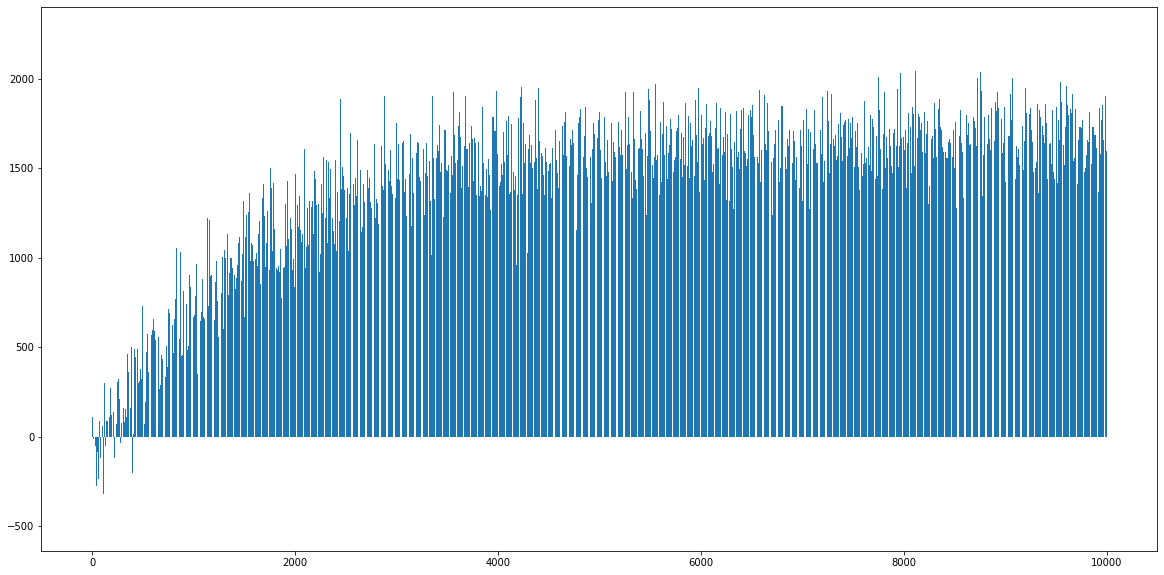

In [13]:
# plot score values

plt.figure(figsize=(20,10))
plt.bar(*zip(*scores.items()))
plt.show()

In [14]:
def plot_lines(data, title):
    """Function to plot reward of each action for given state"""
    i = 1
    fig = plt.figure(figsize=(15,20))
    plt.suptitle('State: ' + title)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for act in data.keys():
        ax = plt.subplot(5,5,i)
        ax.title.set_text('Action ' + act)

        plt.plot(data[act])
        i = i + 1

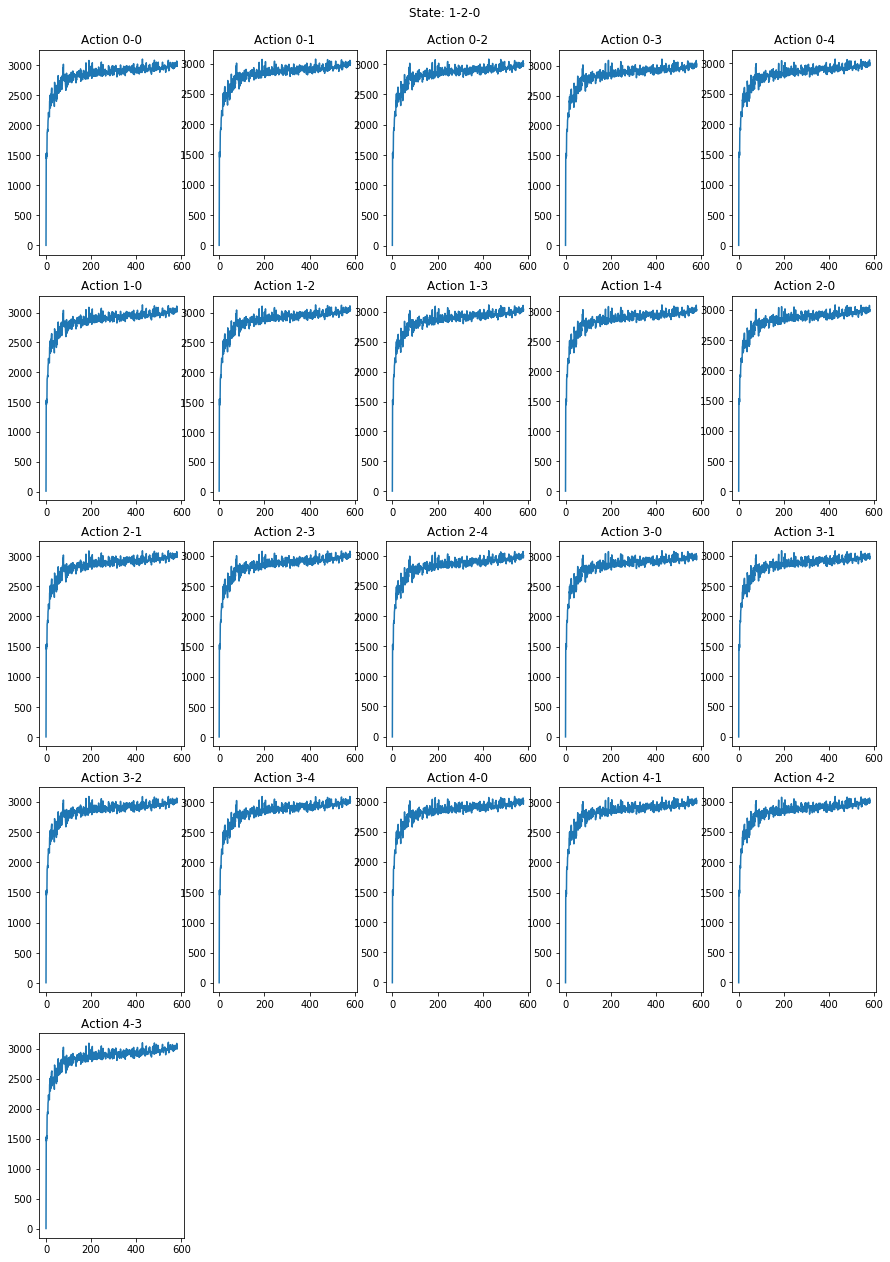

In [15]:
# checking for convergence of state 1-2-0
plot_lines(States_track['1-2-0'], '1-2-0')

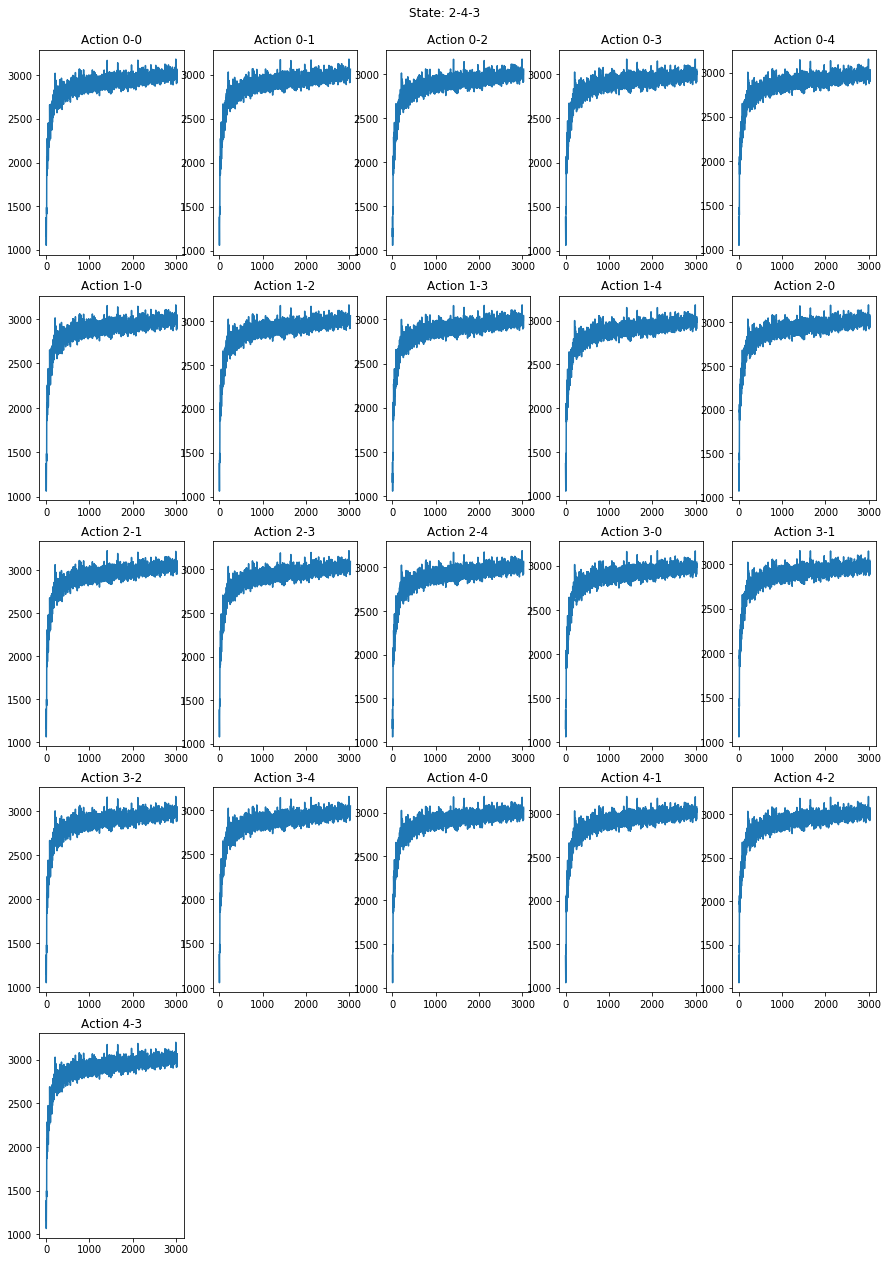

In [16]:
# checking for convergence of state 2-4-3

plot_lines(States_track['2-4-3'], '2-4-3')

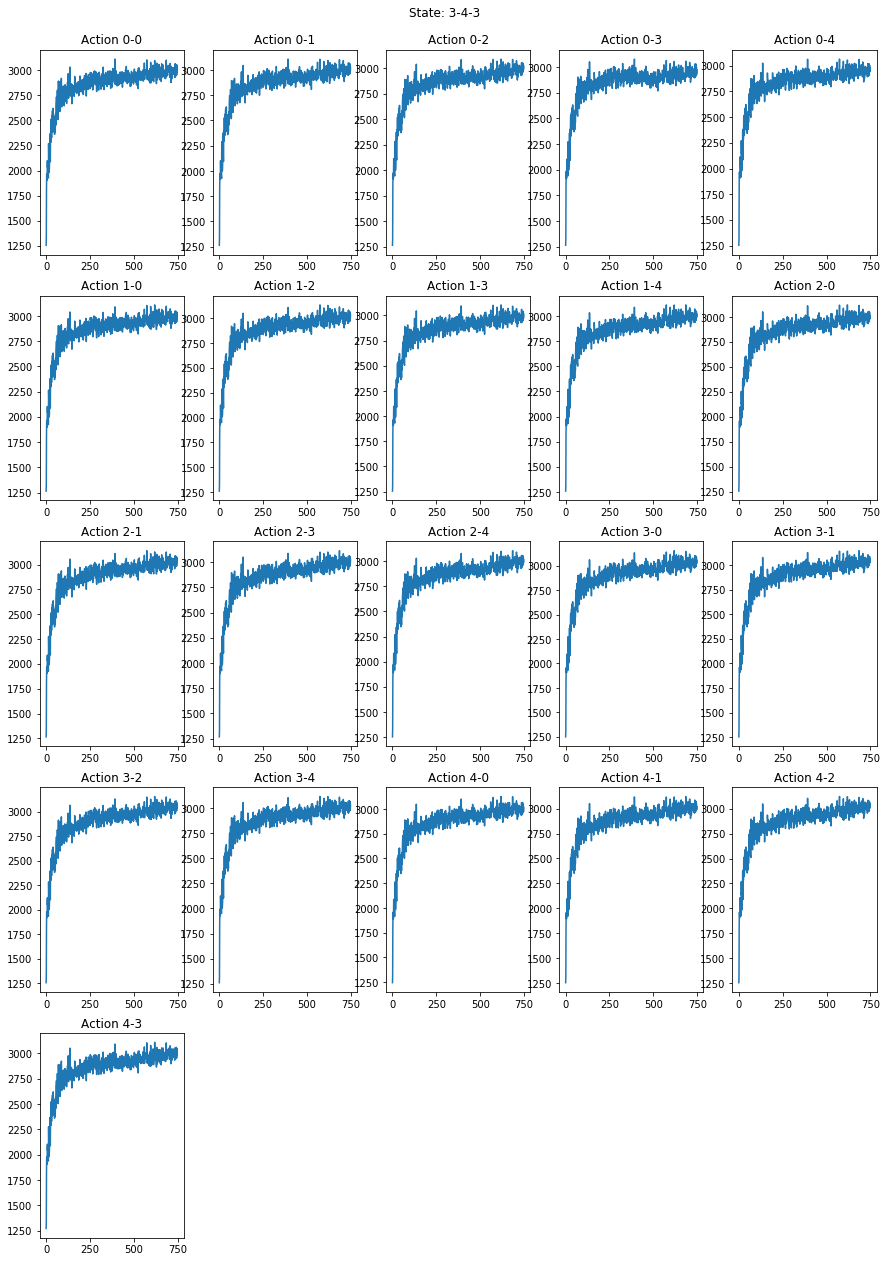

In [17]:
# checking for convergence of state 3-4-3

plot_lines(States_track['3-4-3'], '3-4-3')

### Above plots show that convergence is achieved

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

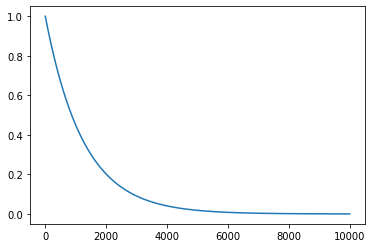

In [18]:
epsilon = []
for i in range(0,Episodes):
    epsilon.append(agent.get_epsilon(i))

plt.plot(np.arange(0,Episodes), epsilon)
plt.show()